# Проект мобильное приложение: выделение групп пользователей на основе поведения

## Материалы:

### Дашборд
1) https://public.tableau.com/profile/soniasemenova#!/vizhome/1_16088033697260/1?publish=yes

### Презентация
2) https://yadi.sk/i/2a51jM4zI58SmQ


### Цель - Выделить группы пользователей по активности. На основе сегментов пользователей понять ключевые факторы, влияющие на активность. Предложить дальнейшую стратегию работы с пользователями, учитывая выявленные факторы.

### Описание данных

Датасет **mobile_dataset.csv** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **mobile_sources.csv** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение
  ##### Расшифровки событий:
- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly
from plotly import graph_objects as go
import math as mth
from scipy import stats as st
from datetime import datetime
from time import strftime
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

### 1. Предобработка данных

In [2]:
events =  pd.read_csv('/datasets/mobile_dataset.csv')
source =  pd.read_csv('/datasets/mobile_soures.csv')

#### 1.1 Проверка данных таблицы events

In [3]:
events.info()
events.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
event.time    74197 non-null object
event.name    74197 non-null object
user.id       74197 non-null object
dtypes: object(3)
memory usage: 1.7+ MB


,event.time,event.name,user.id
72925,2019-11-03 17:45:26.437941,tips_show,6a1f495c-f6dc-475d-a286-ed802d6627be
54849,2019-10-28 01:33:28.653511,tips_show,18d7892a-c92f-4f7c-ad1b-9ca08542554c
11099,2019-10-11 21:00:20.086863,search_5,3bd2c291-242b-4bb9-8762-bb5f74b21acb
7319,2019-10-10 10:10:42.981970,photos_show,79e911b9-ade7-4a4f-8d10-34ef174b0744
45126,2019-10-24 17:43:29.313945,tips_show,87b9b9a1-e7c1-4834-a43e-4510f177f3f9


In [4]:
events.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'}, inplace=True)

In [5]:
events['event_time'] = pd.to_datetime(events['event_time'], format='%Y.%m.%d')

In [6]:
events['date'] = events['event_time'].dt.date

Объединение одинаковых значений событий

In [7]:
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

In [8]:
# заменяю все show_contacts на contacts_show
events['event_name'] = events['event_name'].apply(lambda x: "contacts_show" if x == "show_contacts" else x)

Все таки не решилась объединить разные поиски в одно событие, т.к. search_1 сильно превосходит по количеству другие поиски.

In [9]:
events.isna().sum()

event_time    0
event_name    0
user_id       0
date          0
dtype: int64

In [10]:
events.duplicated().sum()

0

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
event_time    74197 non-null datetime64[ns]
event_name    74197 non-null object
user_id       74197 non-null object
date          74197 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


#### 1.2 Проверка данных таблицы source

In [12]:
source.info()
source.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
userId    4293 non-null object
source    4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


,userId,source
1242,f1ff2a75-3eb2-4347-b731-333d49c14bb4,yandex
4225,9342b2c7-cfe7-4645-83ac-e5940e853c1f,yandex
638,7905e320-bcff-4bf5-9ab4-a87f06be2707,google
1404,f6243b3c-d2c5-4b32-83c7-836e34431693,yandex
1759,76f4ff42-0706-4c62-929c-5d003366fb91,yandex


In [13]:
source.rename(columns={'userId':'user_id'}, inplace=True)

In [14]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
user_id    4293 non-null object
source     4293 non-null object
dtypes: object(2)
memory usage: 67.2+ KB


In [15]:
# объединение таблиц
df = events.merge(source, how='left', on='user_id')

In [16]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 5 columns):
event_time    74197 non-null datetime64[ns]
event_name    74197 non-null object
user_id       74197 non-null object
date          74197 non-null object
source        74197 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 3.4+ MB


,event_time,event_name,user_id,date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex


### 2. Исследовательский анализ данных

#### 2.1 Количественный анализ пользователей и событий

In [17]:
# всего уникальных пользователей
print('Всего уникальных пользователей:', df['user_id'].nunique())

Всего уникальных пользователей: 4293


In [18]:
# всего уникальных пользователей по источникам
t = df.groupby('source')['user_id'].nunique().sort_values(ascending=False).reset_index()
t.columns = ['source', 'count_users']
t

,source,count_users
0,yandex,1934
1,other,1230
2,google,1129


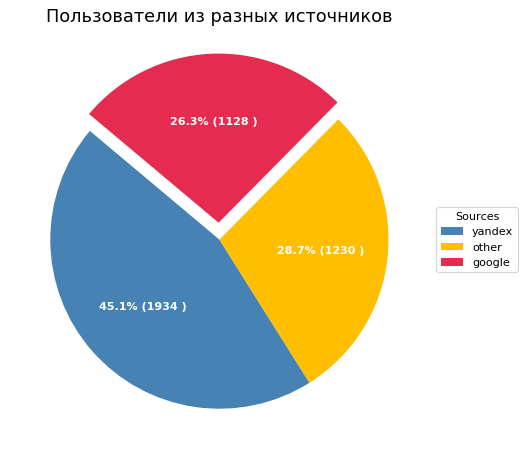

In [19]:
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = t['count_users']
categories = t['source']
explode = [0,0,0.1]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#4682B4', '#FFBF00', '#E52B50'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sources", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Пользователи из разных источников", fontsize=16)
plt.show()

Пользователей из яндекса больше, почти половина от всех.

In [20]:
# количество уникальных пользователей по событиям
t = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).reset_index()
t.columns = ['events', 'count_users']
t

,events,count_users
0,tips_show,2801
1,map,1456
2,photos_show,1095
3,contacts_show,981
4,search_1,787
5,advert_open,751
6,search_5,663
7,search_4,474
8,favorites_add,351
9,search_6,330


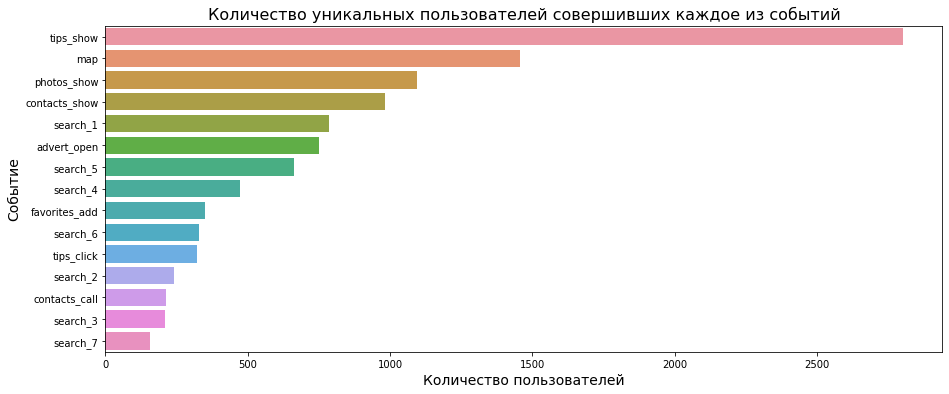

In [21]:
plt.figure(figsize=(15, 6))
sns.barplot(y='events', x='count_users', data=t)
plt.title('Количество уникальных пользователей совершивших каждое из событий', fontsize=16)
plt.xlabel("Количество пользователей", fontsize=14)
plt.ylabel("Событие", fontsize=14)

plt.show()

Лидирует событие "пользователь увидел рекомендованные объявления", возможно в приложении есть лента с рекомендациями, котороя высвечивается сразу, поэтому это событие на первом месте.

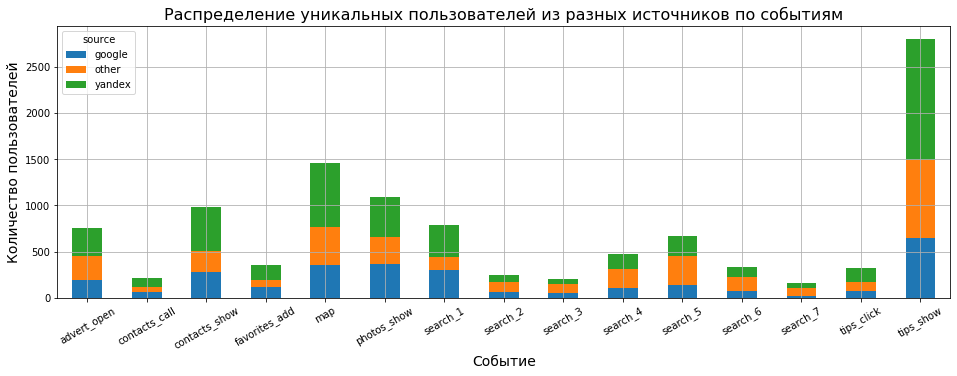

In [22]:
df.pivot_table(index='event_name', columns='source', values='user_id', aggfunc='nunique').plot(kind='bar', stacked=True, grid=True, figsize=(16, 5))
plt.title('Распределение уникальных пользователей из разных источников по событиям', fontsize=16)
plt.ylabel("Количество пользователей", fontsize=14)
plt.xlabel("Событие", fontsize=14)
plt.xticks(rotation=30)
plt.show()

Из каждого ресурса есть пользователи, которые совершали каждое из событий.

#### 2.2 Распеределение событий по времени

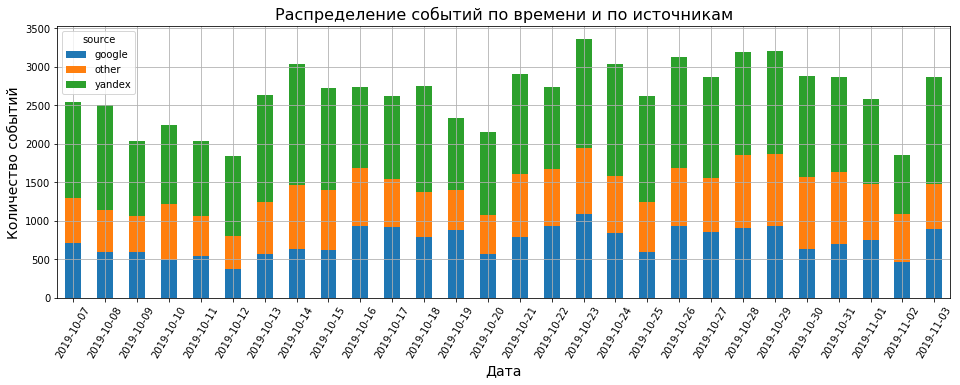

In [23]:
df.pivot_table(index='date', columns='source', values='event_name', aggfunc='count').plot(kind='bar', grid=True, figsize=(16, 5), stacked=True)
plt.title('Распределение событий по времени и по источникам', fontsize=16)
plt.ylabel("Количество событий", fontsize=14)
plt.xlabel("Дата", fontsize=14)
plt.xticks(rotation=60)
plt.show()

Здесь также видно, что данные предоставлены примерно за месяц (период с 2019-10-07 по 2019-11-09).
Распределение событий довольно равномерное, также нет особых перекосов относительно источника.

#### 2.3 Метрики активности

Метрику за месяц мне кажется бессмысленно смотреть, так как у нас все данные только за месяц, а вот недельную и дневную метрики можно посмотреть.

In [24]:
# количество уникальных пользователей в день
dau = df.groupby(['date']).agg({'user_id': 'nunique'}).mean()
print('DAU:', int(dau))

DAU: 279


In [25]:
df['week'] = df['event_time'].dt.week

In [26]:
# количество уникальных пользователей в неделю
wau = df.groupby(['week']).agg({'user_id': 'nunique'}).mean()
print('WAU:', int(wau))

WAU: 1382


In [27]:
sticky_wau = dau / wau *100
sticky_wau

user_id    20.193748
dtype: float64

Стики фактор 20%, мне кажется это неплохой показатель и пользователи довольно активны в приложении. Правда у меня опыта нет сравнить с значениями из других приложений, но вот в википедии было написано что для игр, например, считается нормальным показатель в 18%.

#### 2.4 Конверсия

In [28]:
# конверсия в целевое действие по всем пользователям
(df.query('event_name=="contacts_show"')['user_id'].nunique() / df['user_id'].nunique()) * 100

22.851153039832283

Почти 23% пользователей совершают целевое действие - просмотр контактов.

Сразу сдеалю тут таблицу с конверсией по источникам, она пригодится в дельнейшей проверке гипотез)

In [29]:
t = df.groupby('source')['user_id'].nunique().sort_values(ascending=False).reset_index()
t.columns = ['source', 'count_users']

contacts = df.query('event_name == "contacts_show"').groupby('source')['user_id'].nunique().reset_index()
contacts.columns = ['source', 'users_contact_show']

source_conversion=t.merge(contacts, on='source')
source_conversion['conversion'] = source_conversion['users_contact_show'] / source_conversion['count_users'] * 100

source_conversion

,source,count_users,users_contact_show,conversion
0,yandex,1934,478,24.715615
1,other,1230,228,18.536585
2,google,1129,275,24.357839


У пользователей из яндекса и гугла конверсия получше.

#### 2.5 Длительность сессии

Так как у нас нет никакой информации о конкретных сессиях, я буду делать так: начало сесии - время первого совершенного события пользователя в конкретный день, конец сессии - время последнего события в этот день. (Назввала это сессией, но это не сомвсем так, скорее длительность нахождения пользователя в приложении)

In [30]:
t1 = df.groupby(['user_id', 'date']).agg({'event_time': 'min'}).reset_index()
t1.columns = ['user_id', 'date', 'start_ses']

In [31]:
t2 = df.groupby(['user_id', 'date']).agg({'event_time': 'max'}).reset_index()
t2.columns = ['user_id', 'date', 'end_ses']

In [32]:
d = t1.merge(t2, how='left', on=['user_id', 'date'])

In [33]:
d.head()

,user_id,date,start_ses,end_ses
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098


In [34]:
# считаю длительность сессий в минутах
d['session_duration'] = (d['end_ses'] - d['start_ses']).dt.seconds / 60

In [35]:
d['session_duration'].median()

11.8

(0, 1500)

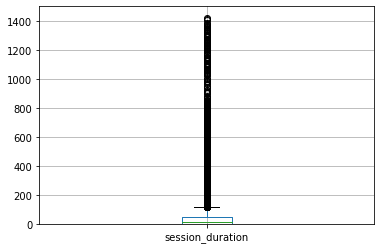

In [36]:
d.boxplot('session_duration')
plt.ylim(0, 1500)

Ого, что то большой хвост получился. Подозреваю это из за пользователей которые совершили 1 действие в день. 

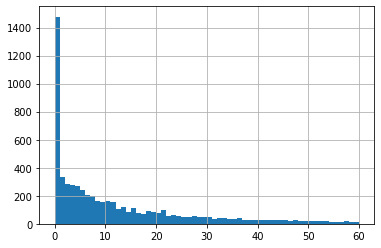

In [37]:
d['session_duration'].hist(bins=60, range=(0, 60))
plt.show()

Тут еще много сессий длительностью 0, но так как в начале по дням группировала там, могло быть так что пользователь начал сессию вечером одного дня, и открыл какую нибудь карточку уже ночью - другой день и это событие записалось как начало следующей сессии. Также если за день было совершено только одно событие, длительность будет 0.

Медианное значение в районе 11 минут. По поему нормально это нормально.

#### 2.6 Активность по пользователеям

Сделаю таблицу с показателями активности по пользователям чтобы в корреляционном анализе использовать.

In [38]:
users = d.groupby('user_id').agg({'date':'count', 'session_duration':'median'}).reset_index()
users.columns = ['user_id', 'active_days', 'mean_session_duration']
users.head()

,user_id,active_days,mean_session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,11.275000
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,30.725000
2,00463033-5717-4bf1-91b4-09183923b9df,1,24.700000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,19.141667
4,00551e79-152e-4441-9cf7-565d7eb04090,3,0.050000


In [39]:
users_conversion = df.groupby('user_id')['event_name'].count().reset_index()
users_conversion.columns = ['user_id', 'users_events_count']

c = df.query('event_name == "contacts_show"').groupby('user_id').agg({'event_name':'count'}).reset_index()
c.columns = ['user_id', 'contacts_show_count']

users_conversion = users_conversion.merge(c, on='user_id', how='left')
users_conversion['conversion'] = users_conversion['contacts_show_count'] / users_conversion['users_events_count']

users_conversion['contacts_show_count'] = users_conversion['contacts_show_count'].fillna(0)
users_conversion['conversion'] = users_conversion['conversion'].fillna(0)

users_conversion.head()

,user_id,users_events_count,contacts_show_count,conversion
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,0.0,0.00000
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,11.0,0.15493
2,00463033-5717-4bf1-91b4-09183923b9df,10,0.0,0.00000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,0.0,0.00000
4,00551e79-152e-4441-9cf7-565d7eb04090,8,3.0,0.37500


In [40]:
users = users.merge(users_conversion, on='user_id', how='left')

In [41]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4293 entries, 0 to 4292
Data columns (total 6 columns):
user_id                  4293 non-null object
active_days              4293 non-null int64
mean_session_duration    4293 non-null float64
users_events_count       4293 non-null int64
contacts_show_count      4293 non-null float64
conversion               4293 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 234.8+ KB


,user_id,active_days,mean_session_duration,users_events_count,contacts_show_count,conversion
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,11.275000,35,0.0,0.00000
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,30.725000,71,11.0,0.15493
2,00463033-5717-4bf1-91b4-09183923b9df,1,24.700000,10,0.0,0.00000
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,19.141667,32,0.0,0.00000
4,00551e79-152e-4441-9cf7-565d7eb04090,3,0.050000,8,3.0,0.37500


In [42]:
# сводная таблица с количеством разных событий по пользователям
piv_events = df.pivot_table(index='user_id', columns='event_name', values='event_time', aggfunc='count').reset_index()
piv_events = piv_events.fillna(0)
piv_events.head()

event_name,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,0.0,33.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00463033-5717-4bf1-91b4-09183923b9df,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,1.0,2.0,6.0,2.0,6.0,0.0,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,0.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2.7 Матрица корреляций

Я сейчас сделаю тут 2 матрицы корреляций, одна будет только по карточкам событий, вторая по карточкам и по посчитаным метрикам активнсоти пользователей.


##### 2.7.1 Матрица корреляций только по карточкам событий

In [43]:
# матрица корреляций только по карточкам событий
cor1 = piv_events.drop(['user_id'], axis=1)
cm1 = cor1.corr()
cm1

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
event_name,,,,,,,,,,,,,,,
advert_open,1.000000,-0.026043,0.052408,0.173891,0.288626,0.028782,-0.020347,0.072410,0.398783,0.161244,0.048576,0.003525,0.089912,0.018592,0.316831
contacts_call,-0.026043,1.000000,0.205595,0.016075,-0.048962,0.145660,0.186397,-0.026312,-0.025374,-0.033359,-0.044152,-0.035327,-0.023356,-0.029889,-0.077278
contacts_show,0.052408,0.205595,1.000000,0.015627,0.317998,0.025482,0.039820,0.001502,0.048719,0.004140,0.073236,0.015025,0.018673,0.214662,0.424281
favorites_add,0.173891,0.016075,0.015627,1.000000,0.185553,0.156049,0.097348,0.021522,0.022209,-0.005395,-0.006209,-0.010354,-0.007958,0.027729,0.144709
map,0.288626,-0.048962,0.317998,0.185553,1.000000,-0.036405,-0.055591,0.046578,0.156845,0.257762,0.113993,0.021042,0.152657,0.226315,0.502292
photos_show,0.028782,0.145660,0.025482,0.156049,-0.036405,1.000000,0.315859,-0.033740,0.001465,-0.049938,-0.066105,-0.059673,-0.039376,-0.049956,-0.096350
search_1,-0.020347,0.186397,0.039820,0.097348,-0.055591,0.315859,1.000000,-0.036125,-0.019315,-0.049899,-0.065621,-0.056388,-0.037075,-0.046345,-0.107406
search_2,0.072410,-0.026312,0.001502,0.021522,0.046578,-0.033740,-0.036125,1.000000,0.092894,0.194665,0.557411,0.226441,0.099098,0.013489,0.069756
search_3,0.398783,-0.025374,0.048719,0.022209,0.156845,0.001465,-0.019315,0.092894,1.000000,0.125558,0.053927,-0.001734,0.016202,0.001420,0.190125


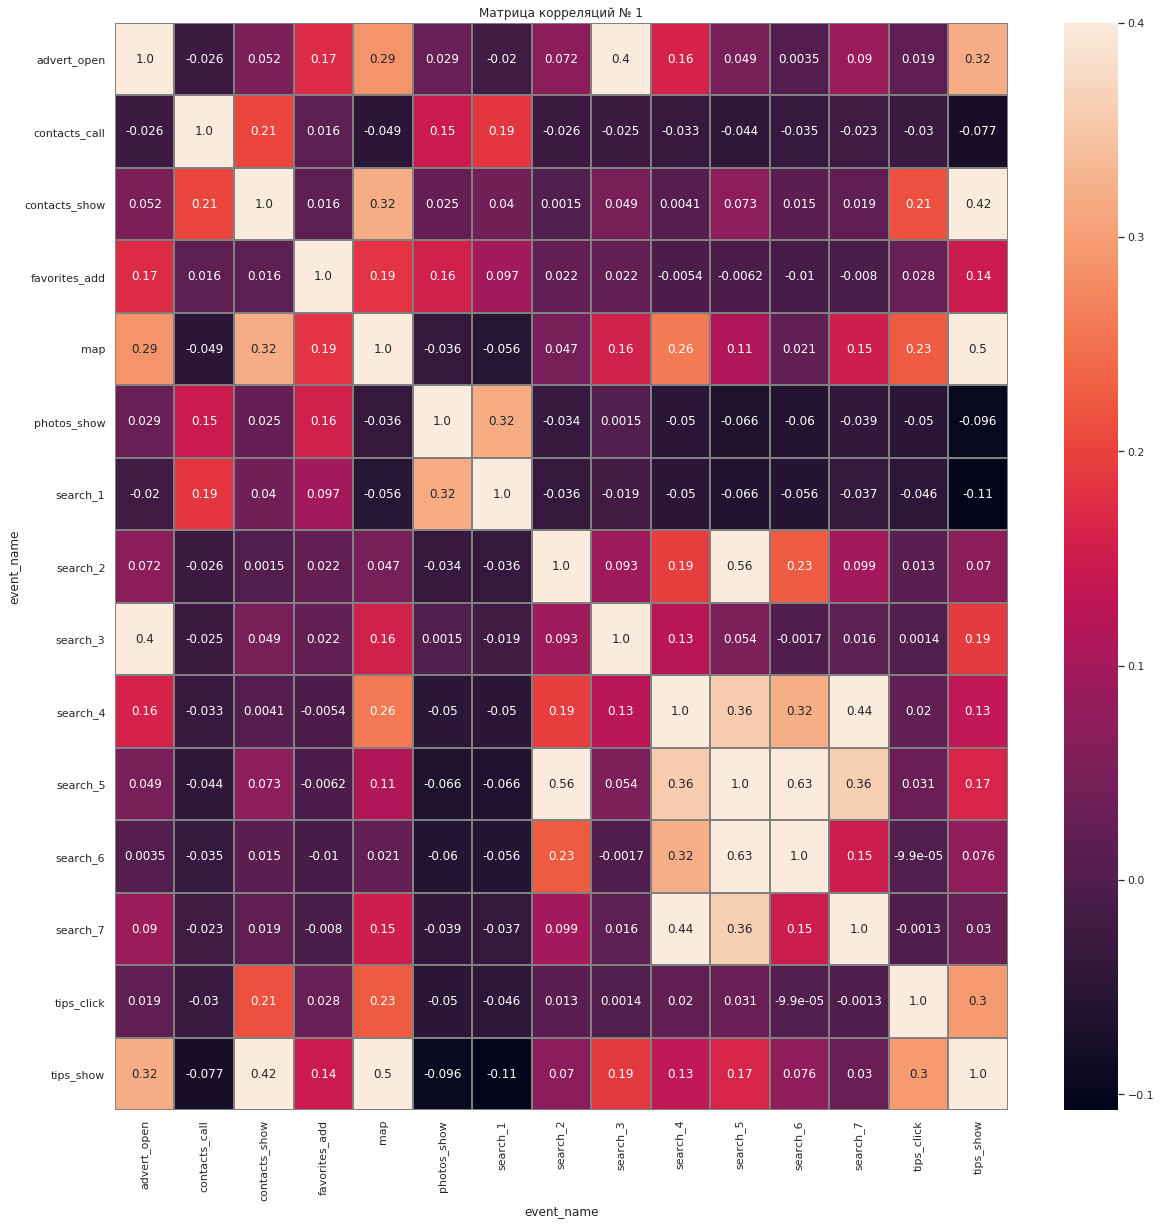

In [44]:
sns.set(style='white')
plt.figure(figsize=(20, 20))
plt.title('Матрица корреляций № 1')
sns.heatmap(cm1, annot = True, fmt='.2', linewidths=1, linecolor='gray', vmax=.4)
plt.show()

Сильных взаимосвязей между событиями нет, но есть некоторая корреляция в поисковых событиях. Например, поиски "search_5" и "search_6"; "search_5" и "search_2", в меньшей степени "search_5" коррелирует с событиями 4 и 7. У "search_1" есть связь с "photos_show", видимо пользователи указывают в запросе что хотят товар с фото. У событий "tips_show" и "tips_click" я надеялась побольше будет взаимосвязь. С "tips_show" неплохо коррелирует "map".

##### 2.7.2 Матрица корреляций по карточкам событий и метрикам активности

In [45]:
users_pivot = users.merge(piv_events, on='user_id')
users_pivot.head()

,user_id,active_days,mean_session_duration,users_events_count,contacts_show_count,conversion,advert_open,contacts_call,contacts_show,favorites_add,...,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,11.275000,35,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,6,30.725000,71,11.0,0.15493,2.0,5.0,11.0,2.0,...,33.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00463033-5717-4bf1-91b4-09183923b9df,1,24.700000,10,0.0,0.00000,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6,19.141667,32,0.0,0.00000,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,6.0,2.0,6.0,0.0,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,3,0.050000,8,3.0,0.37500,0.0,3.0,3.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# матрица корреляций только по карточкам событий и метрикам активности
cor2 = users_pivot.drop(['user_id'], axis=1)
cm2 = cor2.corr()
cm2

,active_days,mean_session_duration,users_events_count,contacts_show_count,conversion,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search_1,search_2,search_3,search_4,search_5,search_6,search_7,tips_click,tips_show
active_days,1.000000,0.035806,0.614803,0.345717,0.037868,0.215137,0.121734,0.345717,0.158560,0.292526,0.326433,0.293832,0.084530,0.157220,0.223133,0.172017,0.084798,0.147483,0.166507,0.458879
mean_session_duration,0.035806,1.000000,0.196747,0.085912,0.015868,0.073900,0.059454,0.085912,0.065781,0.076566,0.062226,0.066963,0.059791,0.042306,0.007517,0.047851,-0.013837,0.026618,0.071118,0.176694
users_events_count,0.614803,0.196747,1.000000,0.535122,0.010131,0.504485,0.055742,0.535122,0.287027,0.584419,0.270355,0.125360,0.102484,0.272016,0.189102,0.187934,0.083938,0.082641,0.285374,0.871107
contacts_show_count,0.345717,0.085912,0.535122,1.000000,0.408226,0.052408,0.205595,1.000000,0.015627,0.317998,0.025482,0.039820,0.001502,0.048719,0.004140,0.073236,0.015025,0.018673,0.214662,0.424281
conversion,0.037868,0.015868,0.010131,0.408226,1.000000,-0.058617,0.312164,0.408226,-0.020441,-0.032439,-0.031546,-0.001722,-0.034410,-0.039174,-0.048096,-0.044890,-0.051067,-0.025160,0.000064,-0.052657
advert_open,0.215137,0.073900,0.504485,0.052408,-0.058617,1.000000,-0.026043,0.052408,0.173891,0.288626,0.028782,-0.020347,0.072410,0.398783,0.161244,0.048576,0.003525,0.089912,0.018592,0.316831
contacts_call,0.121734,0.059454,0.055742,0.205595,0.312164,-0.026043,1.000000,0.205595,0.016075,-0.048962,0.145660,0.186397,-0.026312,-0.025374,-0.033359,-0.044152,-0.035327,-0.023356,-0.029889,-0.077278
contacts_show,0.345717,0.085912,0.535122,1.000000,0.408226,0.052408,0.205595,1.000000,0.015627,0.317998,0.025482,0.039820,0.001502,0.048719,0.004140,0.073236,0.015025,0.018673,0.214662,0.424281
favorites_add,0.158560,0.065781,0.287027,0.015627,-0.020441,0.173891,0.016075,0.015627,1.000000,0.185553,0.156049,0.097348,0.021522,0.022209,-0.005395,-0.006209,-0.010354,-0.007958,0.027729,0.144709
map,0.292526,0.076566,0.584419,0.317998,-0.032439,0.288626,-0.048962,0.317998,0.185553,1.000000,-0.036405,-0.055591,0.046578,0.156845,0.257762,0.113993,0.021042,0.152657,0.226315,0.502292


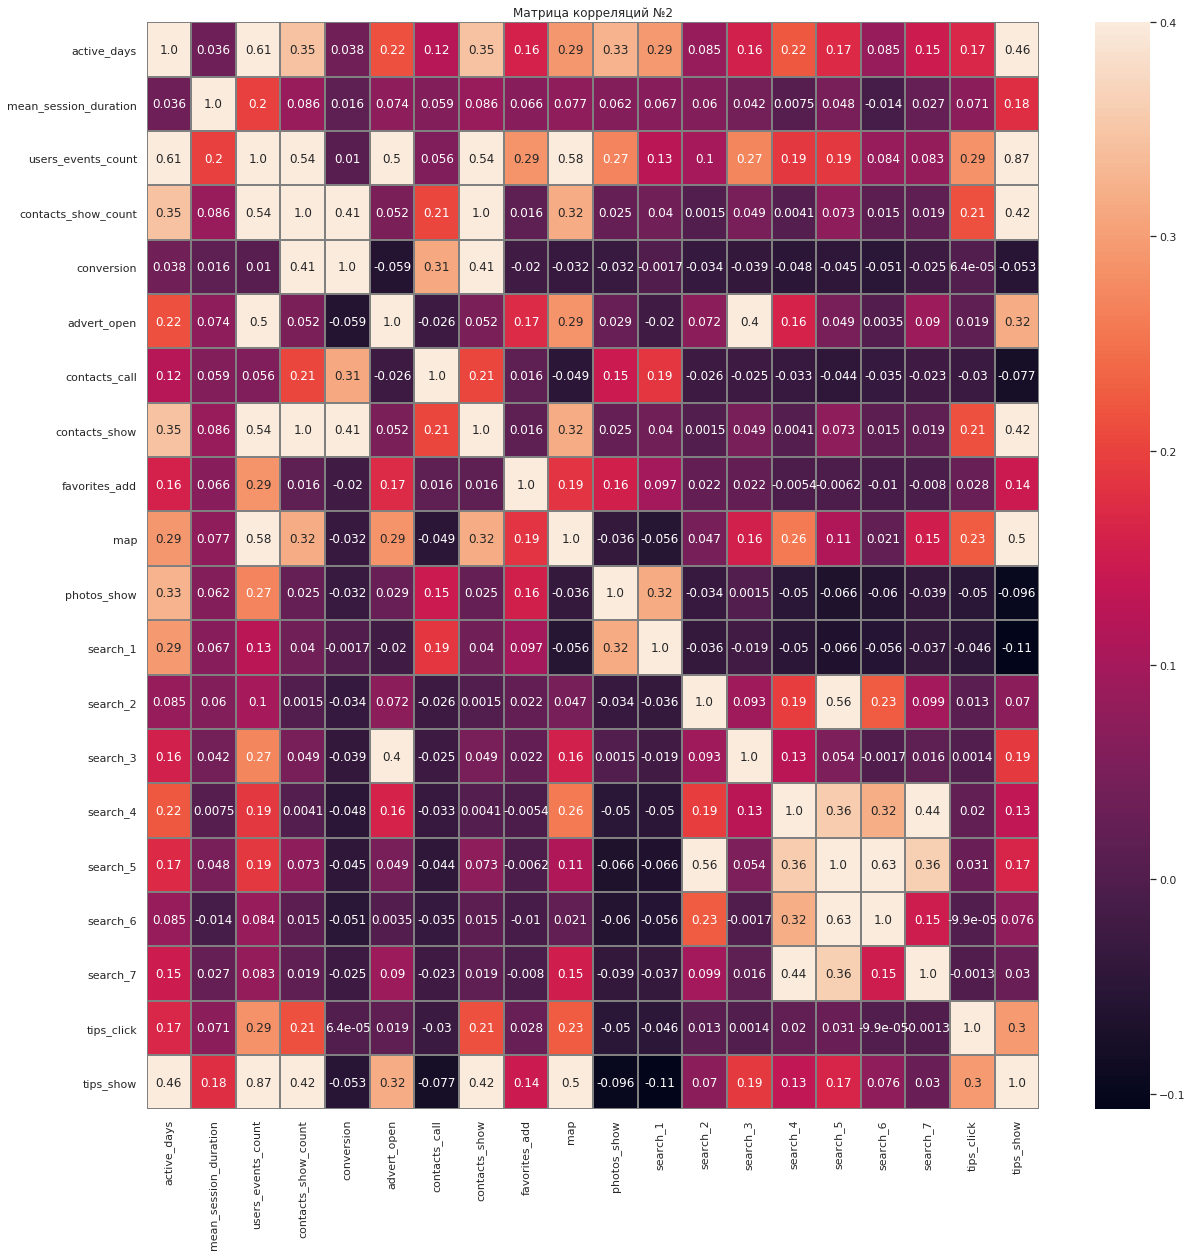

In [47]:
sns.set(style='white')
plt.figure(figsize=(20, 20))
plt.title('Матрица корреляций №2')
sns.heatmap(cm2, annot = True, fmt='.2', linewidths=1, linecolor='gray', vmax=.4)
plt.show()

Тут я хотела посмотреть будет ли связь между показателями активности и определенными событиями. Есть связь между количеством событий на пользователя ("user_events_count") и просомтром карты "map", а также просмотром рекомендованных объявлений "tips_show".

#### 2.8 Дендрограмма

Попробую сделать дендрограмму и посмотреть на какие кластеры будут разбиваться данные. Сделаю это тоже для двух групп: только по карточкам событий и для карточек с метриками.

##### 2.8.1 Дендрограмма по карточкам событий

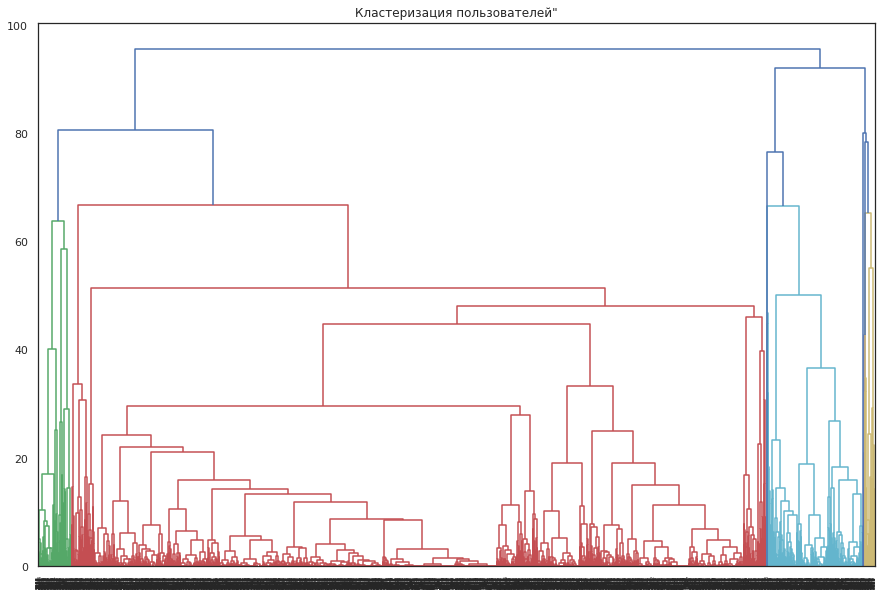

In [48]:
X = piv_events.drop(['user_id'], axis=1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  

dendrogram(linked, orientation='top')

plt.title('Кластеризация пользователей"')
plt.show()

In [49]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters = 4, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [50]:
piv_events['cluster'] = labels

In [51]:
piv_events.groupby('cluster').mean().T

cluster,0,1,2,3
event_name,,,,
advert_open,1.069187,1.685185,2.88,35.973684
contacts_call,0.053620,3.000000,0.00,0.000000
contacts_show,0.747467,5.083333,1.91,20.105263
favorites_add,0.250803,2.250000,0.47,2.947368
map,0.748456,0.111111,1.59,17.921053
photos_show,1.638498,29.666667,0.00,4.657895
search_1,0.613294,9.194444,0.00,0.815789
search_2,0.048184,0.000000,1.13,0.421053
search_3,0.085001,0.000000,0.24,4.052632


In [52]:
piv_events.groupby('cluster')['user_id'].count()

cluster
0    4047
1     108
2     100
3      38
Name: user_id, dtype: int64

 * Кластер "0" 4047 пользователей: открывали в среднем 1 объявление, просматривали 1 фото, небольшая активность в поиске.
 * Кластер "1" 108 пользователей: тоже открывали 1 объявление, но больше других групп просматривали фотографий и больше всех активны в поиске №1.
 * Кластер "2" 100 пользователей: открывали около 3 объявлений, делали разные поисковые запросы и видели много рекомендованных объявлений.
 * Кластер "3" 38 пользователей: самый активный кластер, 35 объявлений, 20 контактов просмотрено, больше других просматривали карту и видели много рекомендованных объявлений.

##### 2.8.2 Дендрограмма по карточкам событий и по метрикам

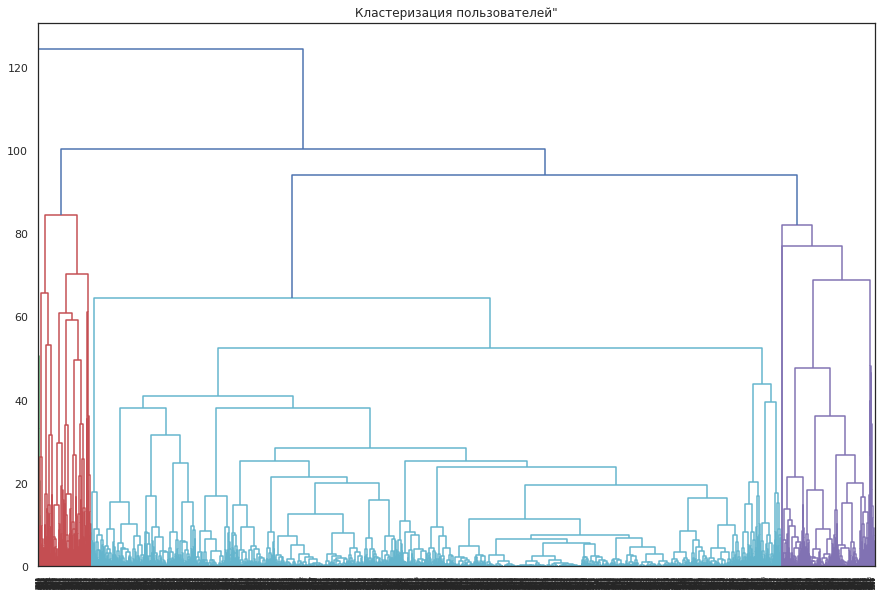

In [53]:
X = users_pivot.drop(['user_id', 'conversion'], axis=1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  

dendrogram(linked, orientation='top')

plt.title('Кластеризация пользователей"')
plt.show()

In [54]:
# задаём модель k_means с числом кластеров 3
km = KMeans(n_clusters = 3, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

In [55]:
users_pivot['cluster'] = labels

In [56]:
users_pivot.groupby('cluster').mean().T

cluster,0,1,2
active_days,1.565228,10.857143,5.481781
mean_session_duration,50.787204,161.525595,118.034615
users_events_count,12.181300,261.785714,86.708502
contacts_show_count,0.676091,70.642857,3.295547
conversion,0.058247,0.389543,0.042234
advert_open,0.750248,5.000000,12.425101
contacts_call,0.115079,0.000000,0.311741
contacts_show,0.676091,70.642857,3.295547
favorites_add,0.204365,0.500000,2.372470
map,0.661706,19.785714,3.789474


In [57]:
users_pivot.groupby('cluster')['user_id'].count()

cluster
0    4032
1      14
2     247
Name: user_id, dtype: int64

Во втором варианте получились группы:
 - 4032 пользователя: малоактивные. Заходили в приложение за месяц 1 раз, посмотрели 1-2 фотографии, меньше остаьных по времени сессии.
 - 14 пользователей: суперактивные. Заходили в среднем 10 раз в приложение за этот месяц, совершали много действие и просматривали около 70 контактов, также увидели много рекомендованных объявлений.
 - 247 пользователя: среднеактивные. 
 
Группы различаются по активности, но вот группа из 14 человек выглядит очень подозрительной. Так как нам нужно на основе поведения активных пользователей дать рекомендации по работе с менее активными, я возьму для анализа первое разделение на 4 группы. Мне кажется, не совсем правильным выбирать стратегию основываясь на поведении такой маленькой группы (14 человек).


Я на самом деле 3 раза делала кластеризацию, добавляя еще столбцы с ресурсами из которых пришли пользователи, но удалили эту дендрограмму, так там совсем какой то получился непонятный разброс пользователей.



#### 2.9 Анализ метрик по группам

In [58]:
s = piv_events[['user_id', 'cluster']]

In [59]:
df1=df.merge(s, how='left', on='user_id')

In [60]:
df1.head()

,event_time,event_name,user_id,date,source,week,cluster
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,41,0
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,41,0
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex,41,0
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other,41,0
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex,41,0


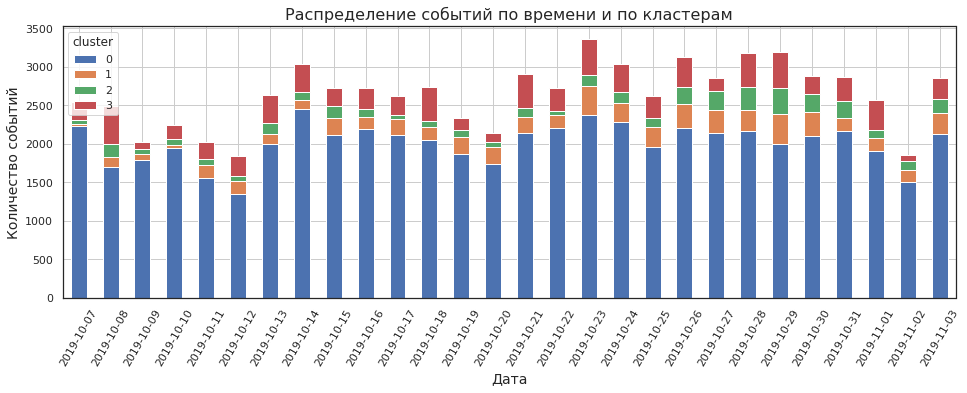

In [61]:
df1.pivot_table(index='date', columns='cluster', values='event_name', aggfunc='count').plot(kind='bar', grid=True, figsize=(16, 5), stacked=True)
plt.title('Распределение событий по времени и по кластерам', fontsize=16)
plt.ylabel("Количество событий", fontsize=14)
plt.xlabel("Дата", fontsize=14)
plt.xticks(rotation=60)
plt.show()

Группы пользователей в соответсвии с кластерами:
* 0 - 4047 пользователей
* 1 - 108 пользователей
* 2 - 100 пользователей 
* 3 - 38 пользователей 

In [62]:
group1 = df1.query('cluster == 0')
group2 = df1.query('cluster == 1')
group3 = df1.query('cluster == 2')
group4 = df1.query('cluster == 3')

##### 2.9.1 Retention rate по группам

Сделала функцию которая считает retention по недельным когортам.

In [63]:
def cohorts_retention_week (data):
    # выделяю дату первой сессии
    data['date']=pd.to_datetime(data['date'])
    first_ses = data.groupby('user_id')['date'].min()
    first_ses.name = 'first_ses_date'
    # присоединяю дату первой сессии к таблице visits
    data = data.join(first_ses, on='user_id')
    # выделяю первую неделю
    data['first_week'] = data['first_ses_date'].astype('datetime64[W]')
    data['n_ses_week'] = data['date'].astype('datetime64[W]')
    # считаю время жизни когорты
    data['cohort_lifetime'] = data['n_ses_week'] - data['first_week']
    data['cohort_lifetime'] = data['cohort_lifetime'] / np.timedelta64(1,'W')
    data['cohort_lifetime'] = data['cohort_lifetime'].round().astype('int')
    # считаю для каждой когорты количество активных пользователей на определённую неделю
    cohorts = data.groupby(['first_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
    # считаю исходное количество пользователей в когорте
    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_week','user_id']]
    initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
    cohorts = cohorts.merge(initial_users_count,on='first_week')
    # считаю retention: количество активных пользователей к общему числу
    cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']
    # сводная таблица по возвращающихся пользователей
    ret = cohorts.pivot_table(index='first_week',columns='cohort_lifetime',values='retention',aggfunc='sum')
    print(ret)

In [64]:
# retention по всем пользователям
cohorts_retention_week(df1)

cohort_lifetime    0         1         2         3         4
first_week                                                  
2019-10-03       1.0  0.270567  0.168190  0.109689  0.071298
2019-10-10       1.0  0.233929  0.154464  0.070536       NaN
2019-10-17       1.0  0.240317  0.088908       NaN       NaN
2019-10-24       1.0  0.173570       NaN       NaN       NaN
2019-10-31       1.0       NaN       NaN       NaN       NaN


In [65]:
# группа 1
cohorts_retention_week(group1)

cohort_lifetime    0         1         2         3         4
first_week                                                  
2019-10-03       1.0  0.249020  0.143137  0.084314  0.043137
2019-10-10       1.0  0.209213  0.122841  0.058541       NaN
2019-10-17       1.0  0.205467  0.065033       NaN       NaN
2019-10-24       1.0  0.155119       NaN       NaN       NaN
2019-10-31       1.0       NaN       NaN       NaN       NaN


In [66]:
# группа 2
cohorts_retention_week(group2)

cohort_lifetime    0         1         2         3         4
first_week                                                  
2019-10-03       1.0  0.615385  0.692308  0.461538  0.384615
2019-10-10       1.0  0.666667  0.600000  0.200000       NaN
2019-10-17       1.0  0.763158  0.447368       NaN       NaN
2019-10-24       1.0  0.565217       NaN       NaN       NaN
2019-10-31       1.0       NaN       NaN       NaN       NaN


In [67]:
# группа 3
cohorts_retention_week(group3)

cohort_lifetime    0         1         2         3         4
first_week                                                  
2019-10-03       1.0  0.529412  0.235294  0.352941  0.352941
2019-10-10       1.0  0.363636  0.545455  0.151515       NaN
2019-10-17       1.0  0.608696  0.217391       NaN       NaN
2019-10-24       1.0  0.521739       NaN       NaN       NaN
2019-10-31       1.0       NaN       NaN       NaN       NaN


In [68]:
# группа 4
cohorts_retention_week(group4)

cohort_lifetime    0         1         2         3         4
first_week                                                  
2019-10-03       1.0  0.571429  0.857143  0.714286  0.857143
2019-10-10       1.0  0.800000  0.600000  0.466667       NaN
2019-10-17       1.0  0.857143  0.714286       NaN       NaN
2019-10-24       1.0  1.000000       NaN       NaN       NaN
2019-10-31       1.0       NaN       NaN       NaN       NaN


У группы 4 самый высокий retention, у 2 и 3 примерно одинаковый, у 1 самый низкий, ну логично самая большая и малоактивная группа получилась.

##### 2.9.2 Время, проведенное в приложении

Функция подсчета времени по каждому пользователю за весь период

In [69]:
def full_time_spent (data):
    t1 = data.groupby(['user_id']).agg({'event_time': 'min'}).reset_index()
    t1.columns = ['user_id','min_time']
    t2 = df.groupby(['user_id']).agg({'event_time': 'max'}).reset_index()
    t2.columns = ['user_id', 'max_time']
    d = t1.merge(t2, how='left', on=['user_id'])
    d['time_spent'] = (d['max_time'] - d['min_time']).dt.seconds / 60
    duration = d[['user_id', 'time_spent']]
    data = data.merge(duration, on='user_id')
    return data

In [70]:
group1 = full_time_spent(group1)

In [71]:
group1['time_spent'].median()

110.51666666666667

In [72]:
group2 = full_time_spent(group2)

In [73]:
group2['time_spent'].median()

765.4

In [74]:
group3 = full_time_spent(group3)

In [75]:
group3['time_spent'].median()

392.53333333333336

In [76]:
group4 = full_time_spent(group4)

In [77]:
group4['time_spent'].median()

796.1666666666666

Как и предполагалось 4 самая активная группа проводит много времени в приложении, но удивительно, что группа 2 немного уступает ей, видимо залипают на фотографиях.

##### 2.9.3 Частота действий

Считаю среднее количество событий на пользователя в каждой из групп

In [78]:
freq1 = group1.groupby('user_id')['event_name'].count().reset_index()
freq1.columns = ['user_id', 'count_event']
freq1['count_event'].median()

8.0

In [79]:
freq2 = group2.groupby('user_id')['event_name'].count().reset_index()
freq2.columns = ['user_id', 'count_event']
freq2['count_event'].median()

44.0

In [80]:
freq3 = group3.groupby('user_id')['event_name'].count().reset_index()
freq3.columns = ['user_id', 'count_event']
freq3['count_event'].median()

32.0

In [81]:
freq4 = group4.groupby('user_id')['event_name'].count().reset_index()
freq4.columns = ['user_id', 'count_event']
freq4['count_event'].median()

180.0

Лидер - группа 4, на 2 месте группа 2, потом 3 и 1.

##### 2.9.4 Конверсия в целевое действие просмотр контакта

In [82]:
group1.query('event_name == "contacts_show" ')['user_id'].nunique() / group1['user_id'].nunique() 

0.21003212255992093

In [83]:
group2.query('event_name == "contacts_show" ')['user_id'].nunique() / group2['user_id'].nunique() 

0.7592592592592593

In [84]:
group3.query('event_name == "contacts_show" ')['user_id'].nunique() / group3['user_id'].nunique() 

0.28

In [85]:
group4.query('event_name == "contacts_show" ')['user_id'].nunique() / group4['user_id'].nunique() 

0.5526315789473685

Неожиданный поворот у группы 4 конверсия в просмотр контактов меньше, чем у группы 2, кажется красивые фотографии как привлечение пользователей работают лучше всего.

In [86]:
metrics = pd.DataFrame({'group': ['group1','group2','group3','group4'],
                    'time_spent': [110.51, 765.4, 392.53, 796.16],
                    'frequency_event': [8, 44, 32, 180],
                    'conversion': [0.21, 0.75, 0.28, 0.55],
                    'four_week_retention' : [0.04, 0.38, 0.35, 0.85]})

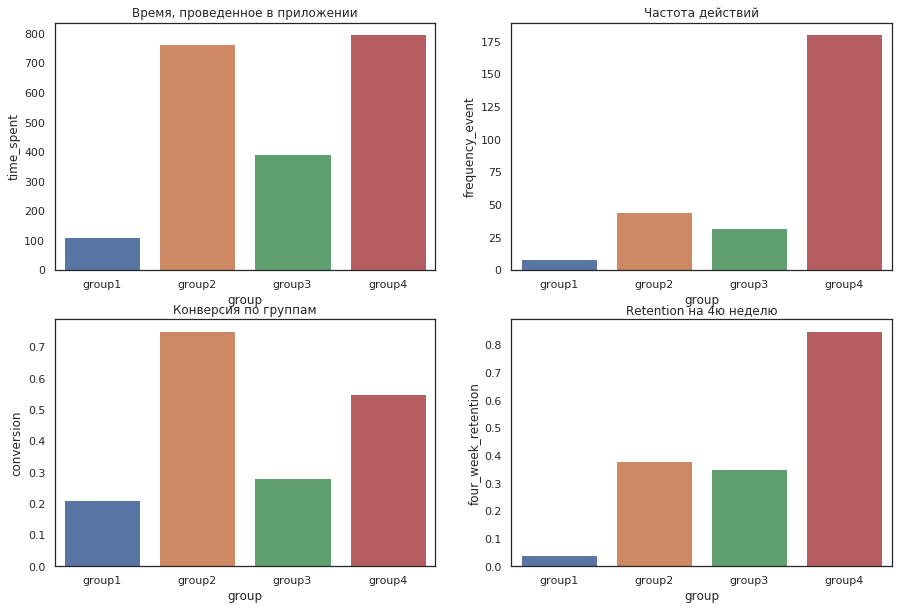

In [87]:
fig, ax = plt.subplots(2 , 2, figsize = (15, 10))
ax1, ax2, ax3, ax4 = ax.flatten()

ax1.set(title='Время, проведенное в приложении')
ax2.set(title='Частота действий')
ax3.set(title='Конверсия по группам')
ax4.set(title='Retention на 4ю неделю')

sns.barplot(metrics['group'], metrics['time_spent'], ax=ax1)
sns.barplot(metrics['group'], metrics['frequency_event'], ax=ax2)
sns.barplot(metrics['group'], metrics['conversion'], ax=ax3)
sns.barplot(metrics['group'], metrics['four_week_retention'], ax=ax4) 

plt.show()

### 3. Проверка статистических гипотез

#####  Конверсия в просмотр контактов у пользователей, установивших приложение по ссылке из yandex больше, чем у пользоватеелей, установивших через google

In [88]:
source_conversion

,source,count_users,users_contact_show,conversion
0,yandex,1934,478,24.715615
1,other,1230,228,18.536585
2,google,1129,275,24.357839


Нулевая гипотеза (H0): Конверсия в просмотр контактов у пользователей, установших приложение по ссылке из yandex и у пользователей, установших приложение по ссылке из google, одинаковая

Альтернативная гипотеза (H1): Конверсия в просмотр контактов у пользователей, установших приложение по ссылке из yandex болльше, чем у пользователей, установших приложение по ссылке из google

In [89]:
alpha = .05 

def z_test (successes1, successes2, trials1, trials2):
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1

    # пропорция успехов во второй группе:
    p2 = successes2/trials2

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    return p_value

In [90]:
p_value = z_test(478, 275, 1934, 1129)
p_value

0.8244316027993777

p_value > alpha - не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными. Конверсия в просмотр контактов у пользователей одинаковая.

##### Конверсия в просмотр контактов у пользователей, увидевшего рекомендованное объявление больше, чем у тех, которые не увидели рекомендованные объявления

Нулевая гипотеза (H0): Конверсия в просмотр контактов у пользователей, которые увидели рекомендованное объявление и тех, кто не увидел рекомендованное объявление, одинаковая

Альтернативная гипотеза (H1): Конверсия в просмотр контактов у пользователей, которые увидели рекомендованное объявление больше, чем у тех кто не увидел рекомендованное объявление

In [91]:
# все пользователи, которые увидели рекомендации
users_pivot.query('tips_show >= 1')['user_id'].nunique()

2801

In [92]:
# все пользователи, которые не увидели рекомендации
users_pivot.query('tips_show == 0')['user_id'].nunique()

1492

In [93]:
# все пользователи, которые увидели рекомендации и просмотрели контакты
users_pivot.query('tips_show >= 1 and contacts_show == 1')['user_id'].nunique()

204

In [94]:
# все пользователи, которые не увидели рекомендации и просмотрели контакты
users_pivot.query('tips_show == 0 and contacts_show >= 1')['user_id'].nunique()

465

In [95]:
p_value = z_test(204, 465, 2801, 1492)
p_value

0.0

p_value < alpha : Отвергаем нулевую гипотезу: между долями есть значимая разница

### Вывод

    1. Всего в данных 4293 пользователя. 45,1% пользователей пришли из источника "yandex", 26,3% из "google" и 28,7% из других источников.

    2. DAU: 279 пользователей,  WAU: 1382, стики фактор 20%. Конверсия - 22,8%. Средняя продолжительность сессии в день 11.8 минут.

    3. Провела сегментацию пользователей на 4 группы:
    - Группа 1: 4047 пользователей. Наименее активные пользователи. В среднем заходили в приложение 1 раз за месяц, просматривали 1 фото, видели около 8 рекомендаций, небольшая активность в поисковых запросах.
    - Группа 2: 108 пользователей. Пользователи больше других групп совершили поиск №1, а также просматривали фотографии. Просматривали контакты меньше, чем группа 4, но сделали больше звонков по контактам.
    - Группа 3: 100 пользователей. Эта группа видела больше рекомендованных объявлений, чем группа 2, но меньше, чем группа 4. Более активна в поисковых запросах №2, №5, №6. Карточки объявлений открывали больше, чем группа 2.
    - Группа 4: 38 пользователей. Наиболее активная группа по открытию карточек объявлений, просмотру рекомендаций, открытии карты и просмотрам контактов. Больше других активна в поиске №3. Но не совершали звонков по контактам, как и  предыдущая группа.


    4. Анализ активности в группах:
    - у группы 4 самый высокий retention, у 2 и 3 примерно одинаковый, у 1 самый низкий;
    - по частоте действий в приложении лидер группа 4, на 2 месте группа 2, потом 3 и 1;
    - группа 4 и 2 проводят много времени в приложении;
    - у группы 4 конверсия в просомтр контактов меньше, чем у группы 2, у 1 и 3 примерно одинаковая.
    

    5. Проверка гипотез
        1) Конверсия в просмотр контактов у пользователей, установших приложение по ссылке из yandex и у пользователей, установших приложение по ссылке из google, одинаковая (подтвердилась нулевая гипотеза)
        2) Конверсия в просмотр контактов у пользователей, которые увидели рекомендованное объявление и тех кто не увидел рекомендованное объявление отличается (подтвердилась альтернативная гипотеза)

### Рекомендации
1. Подробнее изучить поисковой запрос №1, так как у группы №2, которая больше всех делает такой поиск, наиболее высокая конверсия в целевое действие.
2. Конверсия пользователей из источника «yandex» и «google» практически одинаковая, но пользователей из яндекса по количеству гораздо больше. Считаю, что стоит уделить внимание гуглу и привлечь оттуда больше пользователей.
3. Не знаю, как сейчас работают рекомендации, но мне кажется, если рекомендованные объявления показывать не просто как заголовок, а с фотографией, это может увеличить количество кликов по рекомендованному объявлению. Кроме того, из анализа групп выявлено, что у тех кто смотрит фотографии конверсия лучше.
